In [1]:
%matplotlib notebook
from IPython.display import Image

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [88]:
import os
import h5py
import torch
import numpy as np

from sklearn import decomposition

from orthonet import jacob

### Load Data & Model

In [94]:
BASE_PATH = '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/toys/semicirc_sigma2/'
MODEL_PATH = BASE_PATH + 'ortho_vae-3.00e-01_ob3.00e+04_db1.00e+00/'

DATA_PATH  = '/u/xl/tjlane/opt/orthonet/toymodels'

In [95]:
# load some data
f = h5py.File(DATA_PATH + '/bot_quarter_circle_sigma2.00.h5','r')
origin = np.array(f['data'])
r      = np.array(f['r'])
theta  = np.array(f['theta'])
f.close()

In [96]:
def load_model(model_path, original_data):

    model = torch.load(model_path + '/model.pt')

    ot = torch.tensor(original_data.astype(np.float32))
    latent = model.encode(ot).detach().numpy()
    recon  = model(ot)

    # deals with VAE case where I also saved logvar, use only mu here
    if type(recon) == tuple:
        recon = recon[0].detach().numpy()
    else:
        recon = recon.detach().numpy()

    return model, latent, recon

model, latent, recon = load_model(MODEL_PATH, origin)

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### Take a look at the training curves and direct latent space

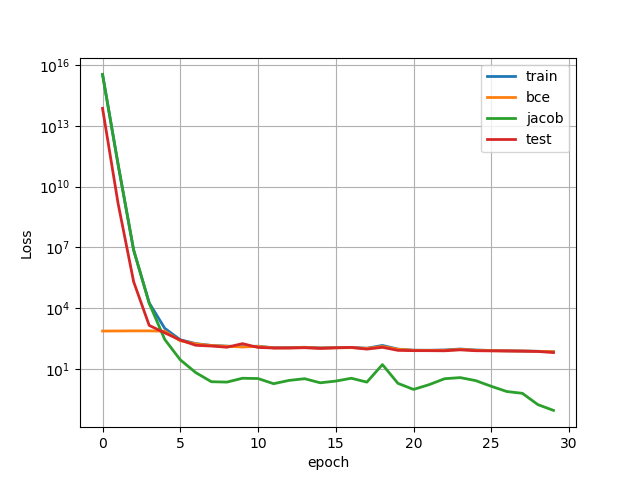

In [97]:
Image(filename=MODEL_PATH + '/loss_curves.png')

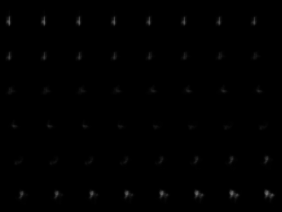

In [98]:
Image(filename=MODEL_PATH + '/z0.png')

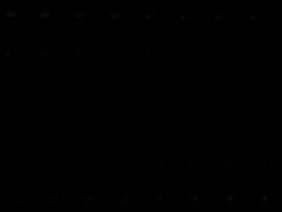

In [99]:
Image(filename=MODEL_PATH + '/z1.png')

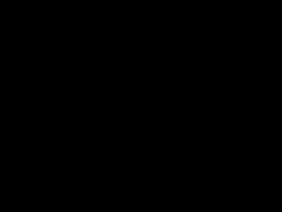

In [100]:
Image(filename=MODEL_PATH + '/z2.png')

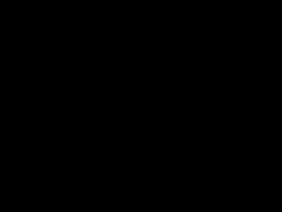

In [101]:
Image(filename=MODEL_PATH + '/z3.png')

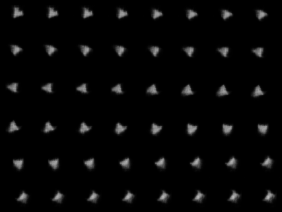

In [102]:
Image(filename=MODEL_PATH + '/z4.png')

### PCA Analysis of Latent Space

<IPython.core.display.Javascript object>


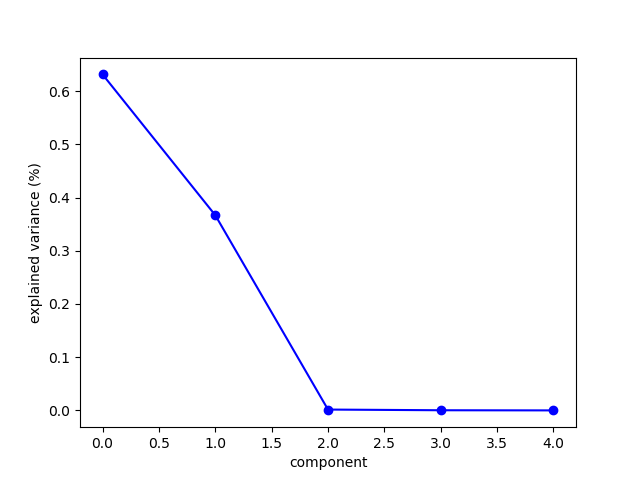

In [103]:
n_components = latent.shape[1]

pca = decomposition.PCA(n_components=n_components)
pca.fit(latent)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.plot(pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

In [81]:
# # trace out the PC space

# samples = 10
# lim = 4 # 2
# res = 0.01 # 0.05
# fps = 60

# #basis = 'pcs'
# basis = 'latent'

# c = 0

# fig = plt.figure()
# ims = []

# limit_list = [(l,l+res) for l in np.arange(-lim,lim,res)]
# print(np.arange(-lim,lim,res))

# for limits in limit_list:

#     s = np.linspace(limits[0], limits[1], num=samples)
#     if basis == 'pcs':
#         z = pca.components_[c]
#     elif basis == 'latent':
#         z = np.eye(n_components)[c]

#     x = torch.tensor(np.outer(s, z).astype(np.float32))
#     rx = model.decode(x).detach().numpy().reshape(-1, 33, 33)

#     ims.append( [plt.imshow(rx.mean(0), animated=True)] )

# ani = animation.ArtistAnimation(fig, ims, interval=fps, blit=True,
#                                 repeat_delay=0)
# #ani.save(MODEL_PATH + '/%s_%d_movie.mp4' % (basis, c), 
# #         fps=fps, extra_args=['-vcodec', 'libx264'])
# plt.show()

(25000, 5)


<IPython.core.display.Javascript object>


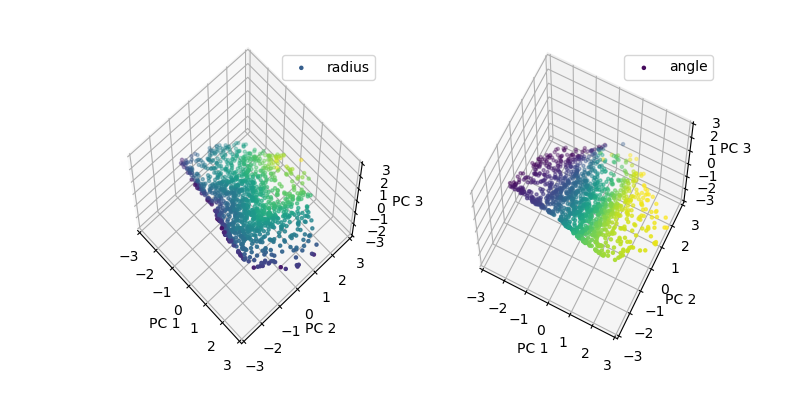

In [110]:
max_pts = 1280
l = 3 # plot limits

latent_in_pc = pca.transform(latent)
print(latent_in_pc.shape)

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=r[:max_pts], marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['radius'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])


ax = fig.add_subplot(122, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=theta[:max_pts], marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['angle'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])

plt.savefig(MODEL_PATH+'/latent.pdf')
plt.show()

### Direct look at the Jacobian of the resulting network

In [108]:
n_samples = 128
n_outputs = torch.tensor(np.product(origin.shape[1:]))

J = np.zeros([1089, 5])
for i in range(n_samples):
    Jx = jacob.jacobian(model.decode, torch.tensor(latent[i]), n_outputs)
    J += Jx.detach().numpy()

<IPython.core.display.Javascript object>


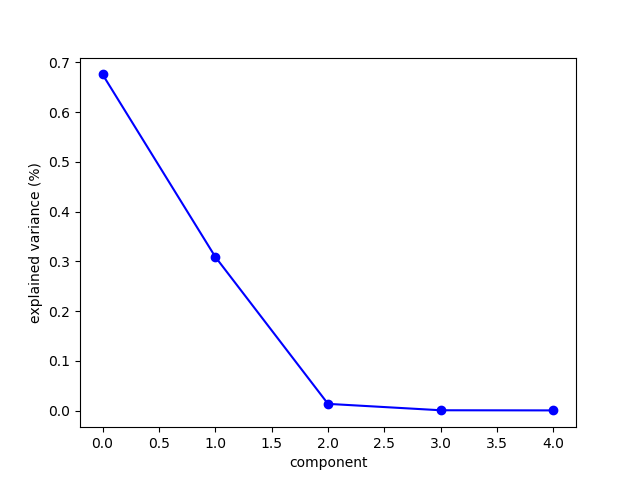

In [84]:
J_pca = decomposition.PCA(n_components=J.shape[1])
J_pca.fit(J)

plt.figure()
plt.plot(J_pca.explained_variance_ratio_, 'bo')
plt.plot(J_pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

<IPython.core.display.Javascript object>


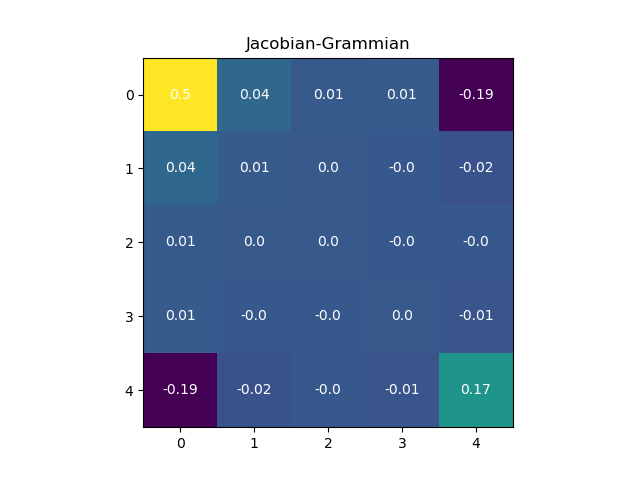

In [109]:
JG = np.dot(J.T, J)

plt.figure()
plt.title('Jacobian-Grammian')
plt.imshow(JG)

for (j,i),label in np.ndenumerate(JG):
    plt.text(i, j, np.round(label,2), ha='center', va='center', color='w')
    
plt.show()

### Investigate the effect of parameters on the dimensionality of the latent space

In [90]:
dbeta = 1.0
obetas = [10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]
vbetas = [0.03, 0.1, 0.3, 1.0, 1.5, 3.0, 10.0]

variance_cutoff = 1e-2

n_dimensions = np.zeros((len(vbetas), len(obetas)))

for i,vbeta in enumerate(vbetas):
    for j,obeta in enumerate(obetas):

        model_path = BASE_PATH + 'ortho_vae-%.2e_ob%.2e_db%.2e' % (vbeta, obeta, dbeta)
        
        if os.path.exists(model_path):
        
            _, latent, _ = load_model(model_path, origin)
            n_components = latent.shape[1]

            pca = decomposition.PCA(n_components=n_components)
            pca.fit(latent)

            nd = np.sum(pca.explained_variance_ratio_ > variance_cutoff)
            print(obeta, vbeta, pca.explained_variance_ratio_)
            n_dimensions[i,j] = nd

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


3000 0.03 [4.3416822e-01 3.6673388e-01 1.9456336e-01 4.4786446e-03 5.5982357e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10000.0 0.03 [0.44925356 0.36061847 0.16747226 0.01624266 0.00641296]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30000.0 0.03 [4.9073923e-01 3.2883057e-01 1.7646649e-01 3.9187563e-03 4.5013501e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100000.0 0.03 [4.7736710e-01 3.8490528e-01 1.3739163e-01 2.5896935e-04 7.7113102e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10 0.1 [3.5781342e-01 2.9438165e-01 2.2157429e-01 1.2621933e-01 1.1315494e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30 0.1 [4.1212013e-01 3.6157703e-01 1.6083483e-01 6.5397799e-02 7.0214352e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100 0.1 [4.8606807e-01 3.2715303e-01 1.4439602e-01 4.2316973e-02 6.5892404e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


300 0.1 [4.8536253e-01 3.4027141e-01 1.7429674e-01 4.9951261e-05 1.9386338e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


1000 0.1 [4.1515225e-01 3.9199832e-01 1.8720214e-01 5.6350259e-03 1.2272731e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


3000 0.1 [5.1586694e-01 4.8388159e-01 1.4450467e-04 8.7757231e-05 1.9148247e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10000.0 0.1 [6.5095681e-01 3.4871817e-01 2.3405466e-04 7.5039214e-05 1.5929712e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30000.0 0.1 [5.3931499e-01 3.5669646e-01 1.0393494e-01 4.4559627e-05 8.9491286e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100000.0 0.1 [0.5557064  0.40645483 0.03644842 0.00075809 0.00063241]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10 0.3 [4.18096691e-01 3.52130800e-01 2.29753166e-01 1.40621705e-05
 5.23278459e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30 0.3 [3.5320505e-01 3.0229950e-01 1.9612153e-01 1.4836198e-01 1.1926309e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100 0.3 [5.51000953e-01 4.48761404e-01 1.60119918e-04 6.41606603e-05
 1.33352505e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


300 0.3 [5.2185428e-01 4.7799489e-01 1.1038796e-04 3.1084255e-05 9.3005001e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


1000 0.3 [5.1991564e-01 4.7993469e-01 9.9250683e-05 4.1217598e-05 9.2754517e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


3000 0.3 [5.9624773e-01 4.0367779e-01 4.6497426e-05 1.9960471e-05 8.0688842e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10000.0 0.3 [6.2897068e-01 3.7022686e-01 4.5560705e-04 1.9809947e-04 1.4866563e-04]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30000.0 0.3 [6.3132572e-01 3.6676759e-01 1.5938542e-03 2.9534718e-04 1.7618353e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100000.0 0.3 [9.9877459e-01 9.4991538e-04 2.3363774e-04 2.8310205e-05 1.3522144e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10 1.0 [5.1102966e-01 4.8891991e-01 3.1123098e-05 1.4718790e-05 4.5603947e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30 1.0 [5.6627655e-01 4.3360692e-01 1.0348605e-04 7.8084904e-06 5.1351412e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100 1.0 [5.7622600e-01 4.2367184e-01 8.9206238e-05 8.8528468e-06 3.9988422e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


300 1.0 [5.2488583e-01 4.7496784e-01 1.2933098e-04 1.0653514e-05 6.3300604e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


1000 1.0 [5.2263743e-01 4.7732803e-01 2.7582017e-05 3.9747420e-06 3.0503129e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


3000 1.0 [5.6146967e-01 4.3839434e-01 1.1590789e-04 1.2128614e-05 8.0521213e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10000.0 1.0 [9.9886900e-01 9.9971949e-04 8.1957376e-05 4.0130330e-05 9.3199324e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30000.0 1.0 [9.9495786e-01 4.8024207e-03 2.2434158e-04 1.2811726e-05 2.5638194e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100000.0 1.0 [9.9959910e-01 3.3260006e-04 4.8348276e-05 1.5522099e-05 4.4054837e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10 1.5 [9.9990547e-01 6.9099828e-05 1.7475038e-05 6.8942350e-06 1.0696858e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30 1.5 [5.517809e-01 4.481600e-01 5.331019e-05 4.216335e-06 1.610610e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100 1.5 [5.2269334e-01 4.7728601e-01 1.6711030e-05 3.3615977e-06 6.7655105e-07]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


300 1.5 [5.4113144e-01 4.5878643e-01 7.2951851e-05 6.9029961e-06 2.2344232e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


1000 1.5 [5.4714954e-01 4.5264053e-01 1.7471812e-04 3.0855852e-05 4.3493474e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10 3.0 [9.99809504e-01 1.11883375e-04 5.94651574e-05 1.75440218e-05
 1.59084141e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30 3.0 [5.33197165e-01 4.66674656e-01 9.16930585e-05 2.20660822e-05
 1.43740035e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100 3.0 [9.9969292e-01 1.6150111e-04 8.9152018e-05 5.4127100e-05 2.2084157e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


300 3.0 [9.9990231e-01 8.8359418e-05 5.1479624e-06 3.4697925e-06 7.9523375e-07]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


1000 3.0 [5.1526672e-01 4.8471364e-01 1.5780091e-05 2.1447242e-06 1.7759007e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10 10.0 [9.9981236e-01 1.3445111e-04 4.3114480e-05 7.0543720e-06 3.0045326e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


30 10.0 [9.9975866e-01 2.0340492e-04 2.4438119e-05 1.0387684e-05 3.1294092e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100 10.0 [9.9995893e-01 2.4440418e-05 1.2488613e-05 3.7013740e-06 4.6387765e-07]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


300 10.0 [9.9974394e-01 2.3838448e-04 1.2215243e-05 4.5825586e-06 9.1640442e-07]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


1000 10.0 [9.3836123e-01 4.9712140e-02 1.0017873e-02 1.4262556e-03 4.8250926e-04]


<IPython.core.display.Javascript object>


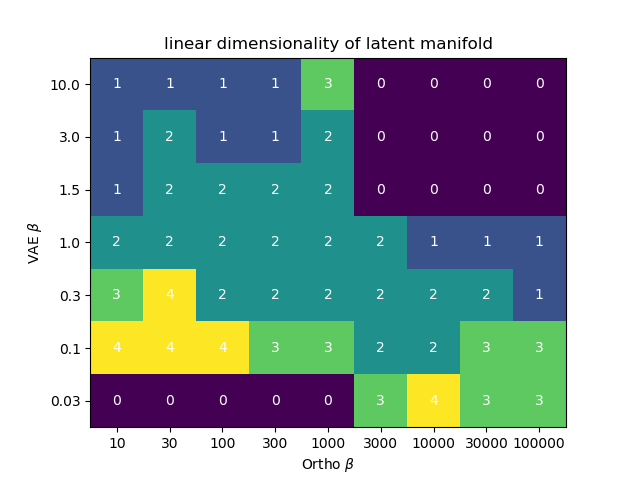

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


In [93]:
plt.figure()

plt.title('linear dimensionality of latent manifold')

ax = plt.subplot(111)
ax.imshow(n_dimensions, aspect=1, origin='bottomleft')

ax.set_yticklabels(['x'] + list(vbetas))
ax.set_xticklabels(['x'] + list(obetas))
plt.ylabel(r'VAE $\beta$')
plt.xlabel(r'Ortho $\beta$')

for (j,i),label in np.ndenumerate(n_dimensions):
    plt.text(i, j, int(label), ha='center', va='center', color='w')

plt.show()